# Task 1 - Kullback-Leibler divergence of two normal distributions

#### The Kullback-Leibler divergence of two continuous distributions P and Q is:
$$ KL(P||Q) = \int_{-\infty}^{\infty} p(x) \log \dfrac{p(x)}{q(x)} dx $$
### - Compute it analytically in the case where P and Q are two normal distributions P = N(μ1,σ1) and Q = N(μ2,σ2)

### 1. What is the specific value of KL(P∥Q) when μ1 =μ2 and σ1 =σ2?

### 2. What are the specific values of KL(P||Q) and KL(Q||P) when μ1 =0, σ1 =2, μ2 =1, σ2 =1?

# Task 2 - Kalman filter smoother

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat                #import mat data

In [2]:
# Load data
mat_file = loadmat('ex5.mat')
#print(mat_file)

# z: latent states -> position and velocity of the drone
z = mat_file['z']

# x: measurements
x = mat_file['x']

# u: external forces
u = mat_file['u']

# model matrices
A = mat_file['A']
B = mat_file['B']
C = mat_file['C']
Sigma = mat_file['Sigma']
Gamma = mat_file['Gamma']

# initial conditions
L0 = mat_file['L0']
mu0 = mat_file['mu0']

### 1) Retrieve an estimate for the latent states ’z’ purely from the observations ’x’ by implementing the Kalman-filter recursions

magari scrivere con latex bene le formule

In [3]:
# useful function for Kalman-filter
def Kt(B, Gamma, Lt_1):
    return Lt_1 @ B.T @ np.linalg.inv( B @ Lt_1 @ B.T + Gamma )

def Vt(B, Kt, Lt_1):
    return ( np.identity(Kt.shape[0]) - Kt @ B ) @ Lt_1

def Lt(A, Sigma, V_t):
    return A @ V_t @ A.T + Sigma

In [4]:
# KALMAN FILTER
def KalmanFilter(A, B, C, Sigma, Gamma, L0, mu0, x, u):
    steps = x.shape[1]
    n = x.shape[0]
    
    # define empty state array
    mu = np.zeros(( n, steps ))
    mu[:,0] = mu0.ravel()
    
    # define empty matrix
    V = np.zeros(( steps, L0.shape[0], L0.shape[1] ))
    
    # compute first element
    K = Kt(B, Gamma, L0)
    V[1,:,:] = Vt(B, K, L0)
    mu[:,1] = A @ mu[:,0] + (C * u[:,1]).reshape(n) + K @ (x[:,1]  - B@( A @ mu[:,0] + (C * u[:,1]).reshape(2) ) )
    
    # loop over time steps
    for i in range(2, steps):
        Lt_1 = Lt(A, Sigma, V[i-1])
        K = Kt(B, Gamma, Lt_1)
        V[i] = Vt(B, K, Lt_1)
        mu[:,i] = A @ mu[:,i-1] + (C * u[:,i]).reshape(n) + K @ (x[:,i] - B@( A @ mu[:,i-1] + C @ u[:,i]) )
        
    return mu, V

In [5]:
# Estimation of variable z with Kalman-filter
mu, V = KalmanFilter(A, B, C, Sigma, Gamma, L0, mu0, x, u)

### 2) Plot the obtained predicted latent states against the true latent states (in variable ’z’)

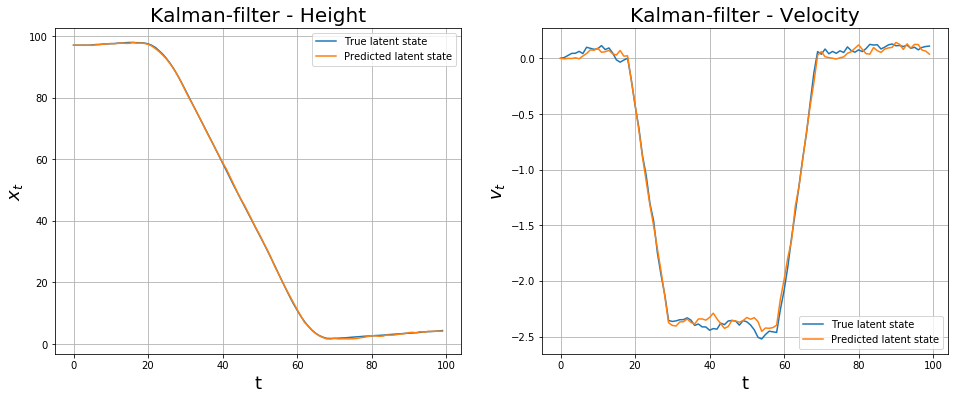

In [6]:
# Plot the time series
fig1 = plt.subplots(figsize=[16,6])

plt.subplot(1,2,1)
plt.plot(np.arange(z.shape[1]), z[0], label='True latent state' )
plt.plot(np.arange(z.shape[1]), mu[0], label='Predicted latent state' )
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Kalman-filter - Height', fontsize = 20)

plt.subplot(1,2,2)
plt.plot(np.arange(z.shape[1]), z[1], label='True latent state'  )
plt.plot(np.arange(z.shape[1]), mu[1], label='Predicted latent state')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$v_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Kalman-filter - Velocity', fontsize = 20)

plt.show(fig1)

### How well can you recover the true latent states? What could the drone be doing?

### 3) Examine the parameter values of A and C? Why are they chosen the way they are?

In [7]:
print('Parameter A:\n', A)
print('Parameter C:\n', C)

Parameter A:
 [[1 1]
 [0 1]]
Parameter C:
 [[0.5]
 [1. ]]


Scrivere qualcosa

### 4) Now implement the Kalman-’smoother’

In [8]:
# KALMAN SMOOTHER
def KalmanSmoother(A, C, Sigma, Vt, Lt, mu, u):
    T = mu.shape[1]
    n = mu.shape[0]
    
    mu_tilde = np.zeros(( n, T ))
    
    # define last element
    mu_tilde[:,-1] = mu[:,-1]
    
    for i in range(1,T):
        L = Lt(A, Sigma, Vt[T-i,:,:])
        mu_tilde[:,T-1-i] = mu[:,T-1-i] + Vt[T-1-i,:,:]@A.T@np.linalg.inv(L)@(mu_tilde[:,T-i] - A@mu[:,T-1-i] - C@u[:,T-1-i])
        
    return mu_tilde

### 5) Apply the Kalman-filter-smoother to obtain estimates for your latent state path

In [9]:
# Estimation of variable z with Kalman-smoother
mu_tilde = KalmanSmoother(A, C, Sigma, V, Lt, mu, u)

Scrivere qualcosa

### Plot the obtained predicted latent states against the true latent states (variable ’z’), and against the latent states obtained by only using the filter

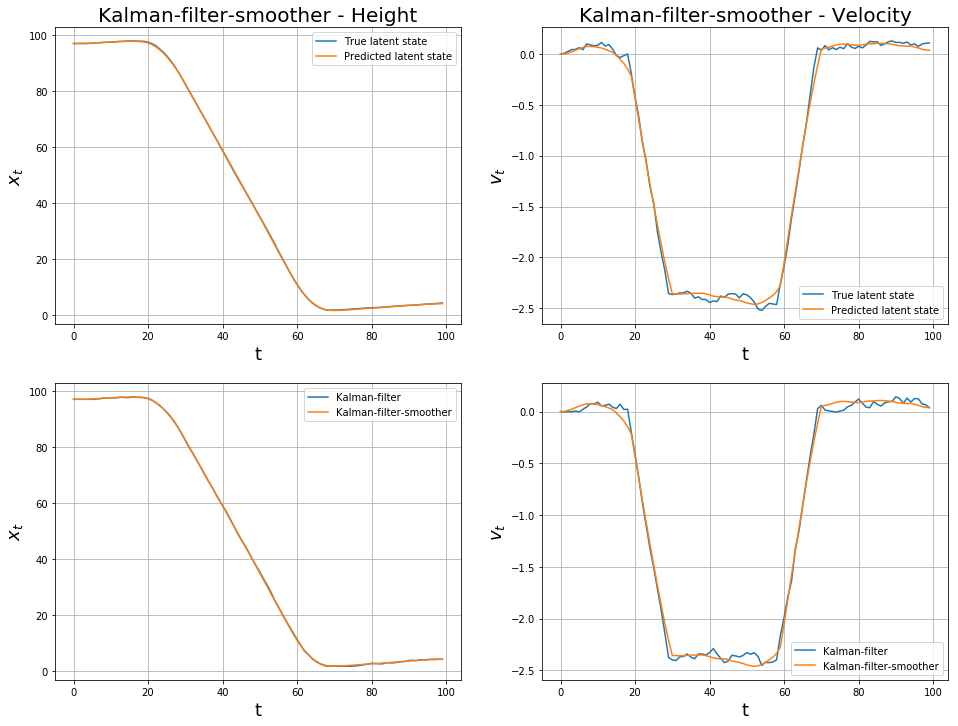

In [10]:
# Plot the time series
fig1 = plt.subplots(figsize=[16,12])

plt.subplot(2,2,1)
plt.plot(np.arange(z.shape[1]), z[0], label='True latent state' )
plt.plot(np.arange(z.shape[1]), mu_tilde[0], label='Predicted latent state' )
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Kalman-filter-smoother - Height', fontsize = 20)

plt.subplot(2,2,2)
plt.plot(np.arange(z.shape[1]), z[1], label='True latent state'  )
plt.plot(np.arange(z.shape[1]), mu_tilde[1], label='Predicted latent state')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$v_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Kalman-filter-smoother - Velocity', fontsize = 20)

plt.subplot(2,2,3)
plt.plot(np.arange(z.shape[1]), mu[0], label='Kalman-filter' )
plt.plot(np.arange(z.shape[1]), mu_tilde[0], label='Kalman-filter-smoother' )
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.arange(z.shape[1]), mu[1], label='Kalman-filter'  )
plt.plot(np.arange(z.shape[1]), mu_tilde[1], label='Kalman-filter-smoother')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$v_t$', fontsize = 18)
plt.grid()
plt.legend()

plt.show(fig1)

### Quantify these results by computing the mean squared error between true and recovered latent states

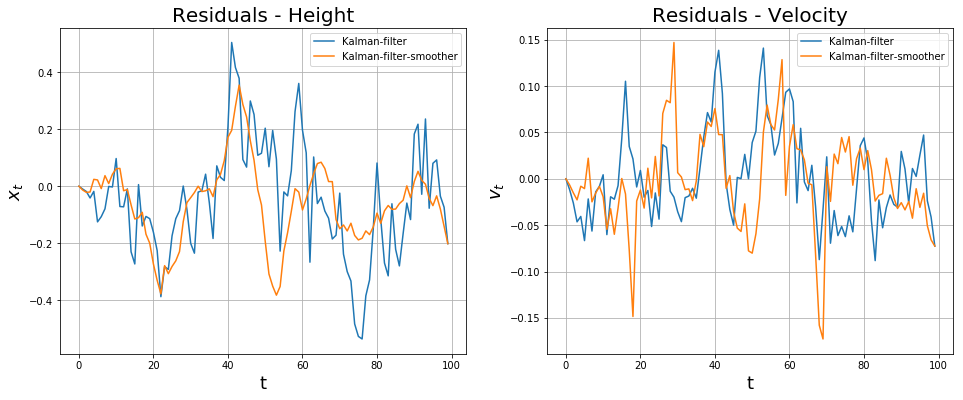

In [11]:
# Plots of the residuals respect to the true latent state
fig1 = plt.subplots(figsize=[16,6])

plt.subplot(1,2,1)
plt.plot(np.arange(z.shape[1]), mu[0] - z[0], label='Kalman-filter' )
plt.plot(np.arange(z.shape[1]), mu_tilde[0] - z[0], label='Kalman-filter-smoother' )
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Residuals - Height', fontsize = 20)

plt.subplot(1,2,2)
plt.plot(np.arange(z.shape[1]), mu[1] - z[1], label='Kalman-filter'  )
plt.plot(np.arange(z.shape[1]), mu_tilde[1] - z[1], label='Kalman-filter-smoother')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$v_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Residuals - Velocity', fontsize = 20)

plt.show()

In [12]:
# Compute MSE - position
KF_pos = np.mean( (mu[0] - z[0])**2 )
KF_vel = np.mean( (mu[1] - z[1])**2 )
KFS_pos = np.mean( (mu_tilde[0] - z[0])**2 )
KFS_vel = np.mean( (mu_tilde[1] - z[1])**2 )

print('Mean-squared error for Kalman-filter:')
print('Height: %.4f' % KF_pos)
print('Velocity: %.4f' % KF_vel)


print('Mean-squared error for Kalman-filter-smoother:')
print('Height: %.4f' % KFS_pos)
print('Velocity: %.4f' % KFS_vel)

Mean-squared error for Kalman-filter:
Height: 0.0411
Velocity: 0.0024
Mean-squared error for Kalman-filter-smoother:
Height: 0.0235
Velocity: 0.0027


### How do they differ?

Scrivere qualcosa